In [93]:
%matplotlib inline
#%matplotlib notebook

In [94]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import numpy as np
from numpy import median
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [95]:
inputs = [
    ["Experiment_Tube_005_005.fcs",0,0,'WT'],
    ["Experiment_Tube_006_006.fcs",1e-4, 0,'WT'],
    ["Experiment_Tube_007_007.fcs",1e-4, 1e-3,'Lux'],
    ["Experiment_Tube_009_009.fcs",1e-6, 1e-3,'Lux'],
    ["Experiment_Tube_010_010.fcs",1e-8, 1e-3,'Lux'],
    ["Experiment_Tube_011_011.fcs",1e-10, 1e-3,'Lux'],
    ["Experiment_Tube_012_012.fcs",1e-12,1e-3,'Lux'],
    ["Experiment_Tube_013_013.fcs",1e-4,0,'Lux'],
    ["Experiment_Tube_014_014.fcs",1e-6, 0,'Lux'],
    ["Experiment_Tube_015_015.fcs",1e-8, 0,'Lux'],
    ["Experiment_Tube_016_016.fcs",1e-10, 0,'Lux'],
    ["Experiment_Tube_017_017.fcs",1e-12, 0,'Lux'],
 
]

       
tubes = []
for filename, ahl, iptg, family in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg, 'Family' : family}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'Family' : 'str'},
                   tubes = tubes).apply()
       


In [96]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


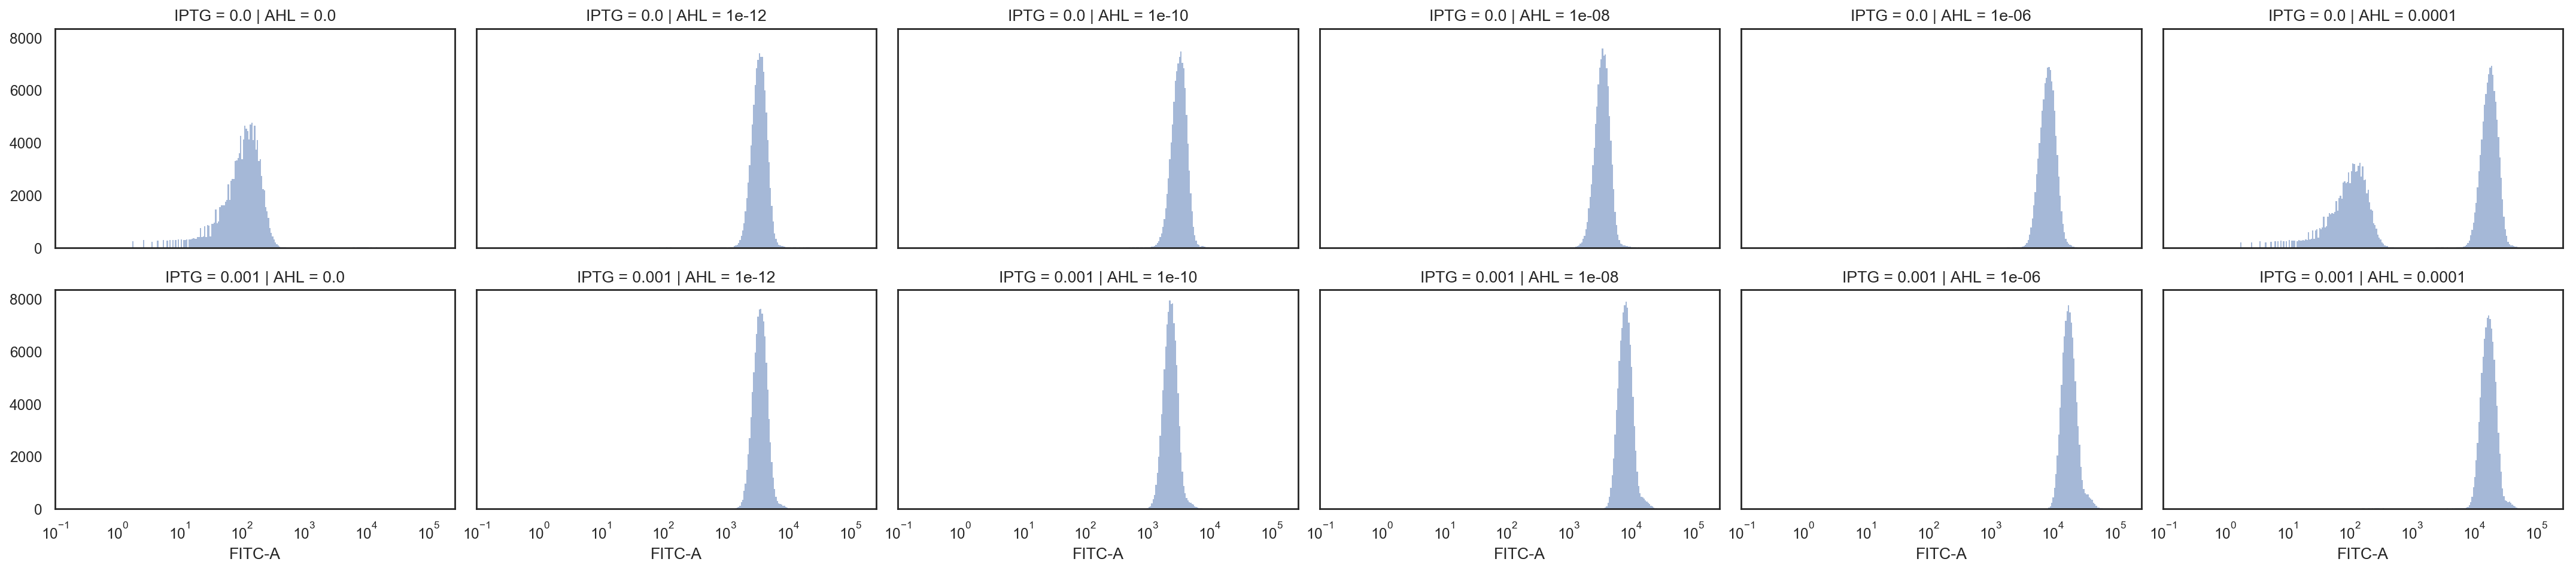

In [97]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

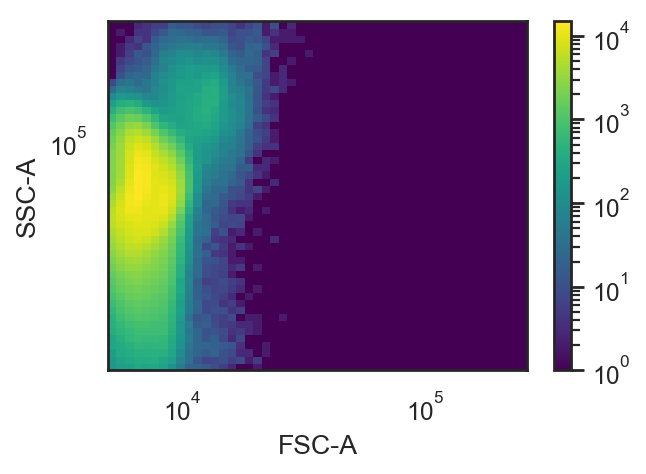

In [98]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

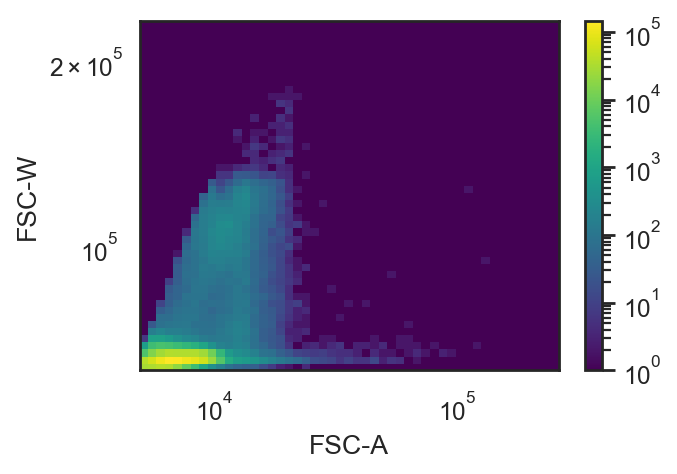

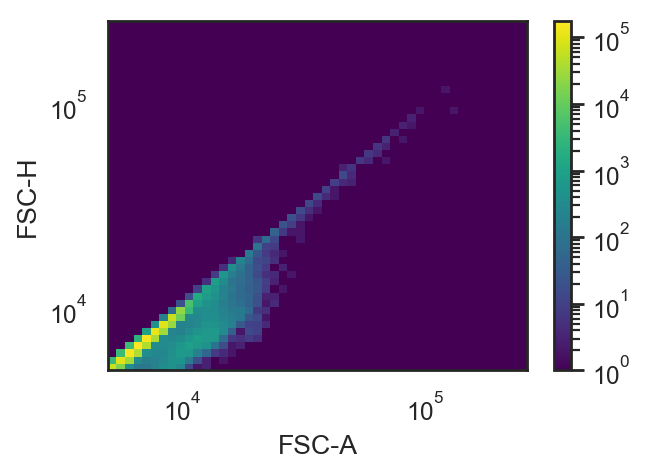

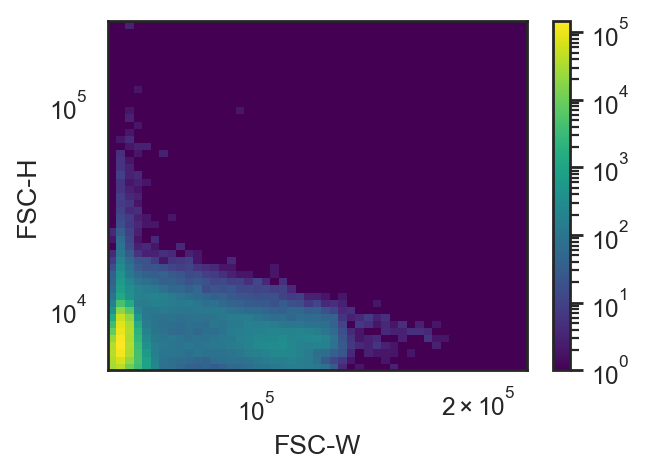

In [99]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


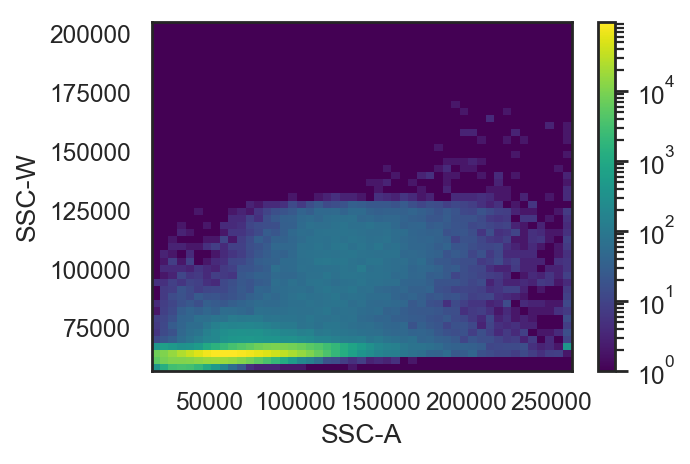

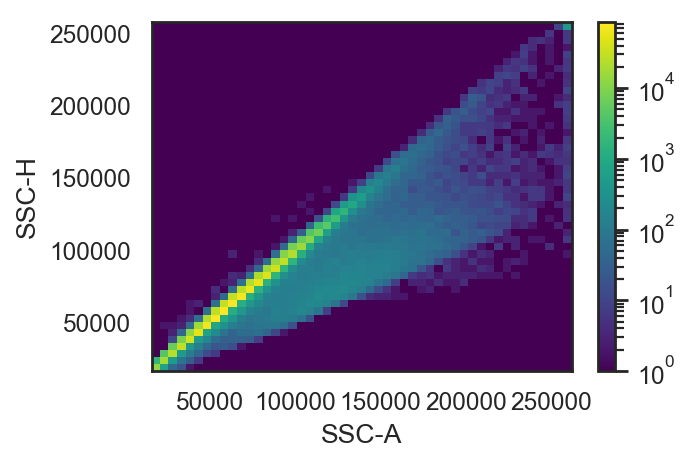

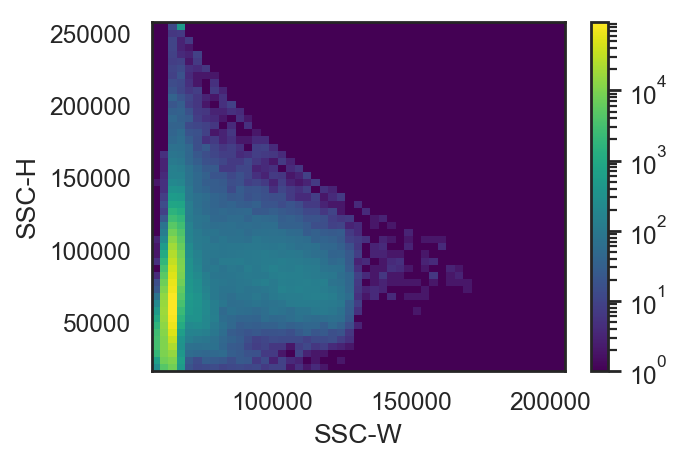

In [100]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

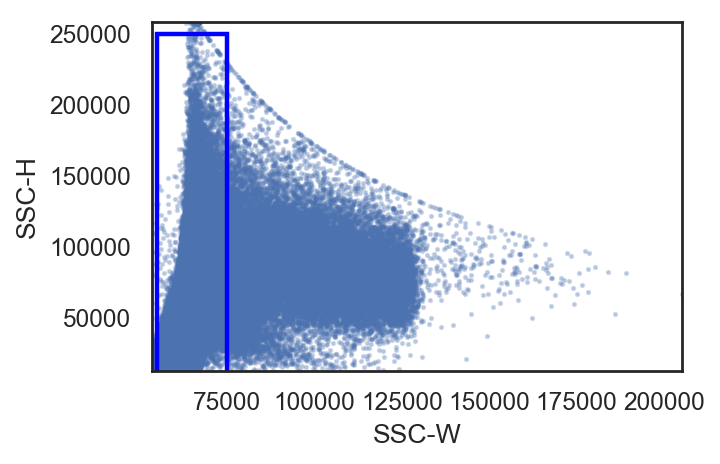

In [101]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


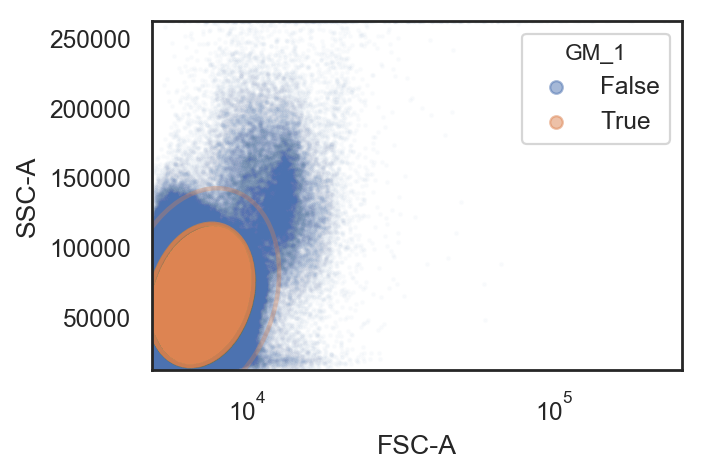

In [102]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


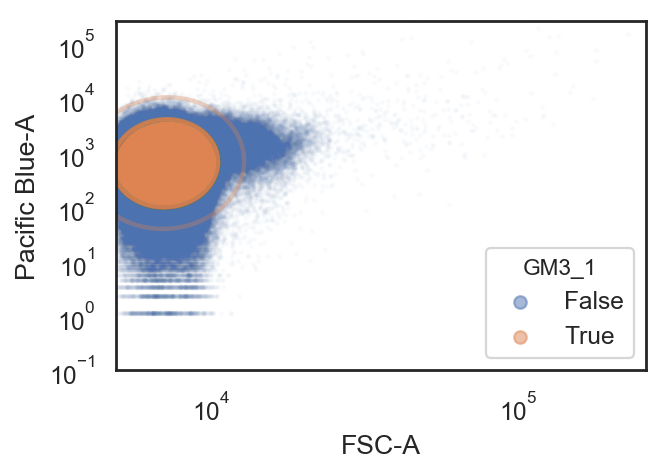

In [103]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [104]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [105]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,Family,IPTG,Pacific Blue-A,...,Pacific Blue-W,PerCP-Cy5-5-A,PerCP-Cy5-5-H,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,0.000000e+00,141.509995,112.0,82803.554688,5285.080078,5364.0,64571.773438,WT,0.0,641.700012,...,75097.234375,11102.750000,11380.0,32790.269531,36144.0,59455.042969,52.200001,True,True,True
1,0.000000e+00,25.809999,99.0,17085.697266,5224.399902,5287.0,64760.031250,WT,0.0,1240.849976,...,62029.250000,7614.839844,7151.0,49845.339844,51991.0,62831.339844,52.200001,True,True,True
3,0.000000e+00,169.989990,298.0,37384.109375,7594.620117,7646.0,65095.609375,WT,0.0,1514.549927,...,61919.863281,14042.419922,13431.0,86477.742188,87738.0,64594.652344,52.299999,True,True,True
5,0.000000e+00,188.679993,290.0,42639.078125,6767.300293,6694.0,66253.632812,WT,0.0,1269.599976,...,47008.195312,14737.509766,13934.0,104496.679688,105362.0,64997.765625,52.500000,True,True,True
6,0.000000e+00,47.169998,146.0,21173.513672,5157.060059,5206.0,64919.917969,WT,0.0,882.049988,...,77800.843750,8974.759766,9319.0,34941.398438,36566.0,62624.285156,52.500000,True,True,True
7,0.000000e+00,113.919998,66.0,113119.109375,5632.140137,5750.0,64192.683594,WT,0.0,2664.550049,...,70726.593750,9010.359375,8709.0,58063.597656,57974.0,65637.281250,52.599998,True,True,True
8,0.000000e+00,70.309998,118.0,39049.457031,6362.520020,6450.0,64647.144531,WT,0.0,783.149963,...,32218.779297,9924.389648,10206.0,60223.628906,62229.0,63424.058594,52.700001,True,True,True
9,0.000000e+00,209.149994,228.0,60117.777344,6286.300293,6368.0,64695.191406,WT,0.0,1159.199951,...,59443.914062,10073.910156,9802.0,101044.367188,103188.0,64174.554688,52.700001,True,True,True
10,0.000000e+00,210.039993,246.0,55956.019531,7132.859863,7170.0,65196.535156,WT,0.0,2428.800049,...,57215.617188,15332.029297,15482.0,106264.218750,108150.0,64393.269531,52.799999,True,True,True
11,0.000000e+00,121.040001,51.0,155538.781250,6987.080078,7223.0,63395.445312,WT,0.0,363.399994,...,27002.021484,8314.379883,8838.0,70467.531250,73303.0,63000.968750,52.799999,True,True,True


In [107]:
data = df[['FITC-A','AHL','IPTG','Family']]
data.insert(4,'Replicate',2)
data.to_pickle('../compiled-data/se/lux/LuxSE_2.pkl')


In [181]:
# Subtract WT background from samples
data = df[['FITC-A','AHL','IPTG','Family']]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
data['FITC-A'] = data[data['FITC-A'] > 0]['FITC-A']
data = data[data.Family=='Lux']
data.drop('Family',inplace=True,axis=1)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [164]:
data['FITC-A'].min()

0.640482506392118

In [150]:
data

,FITC-A,AHL,IPTG
238550,16702.379778,1.000000e-04,0.001
238551,10938.740130,1.000000e-04,0.001
238552,17288.889544,1.000000e-04,0.001
238553,14492.510638,1.000000e-04,0.001
238554,14956.200091,1.000000e-04,0.001
238555,14083.110247,1.000000e-04,0.001
238556,22245.299700,1.000000e-04,0.001
238557,14918.820208,1.000000e-04,0.001
238558,13234.940325,1.000000e-04,0.001
238559,11551.950091,1.000000e-04,0.001


# Plot median FITC-A

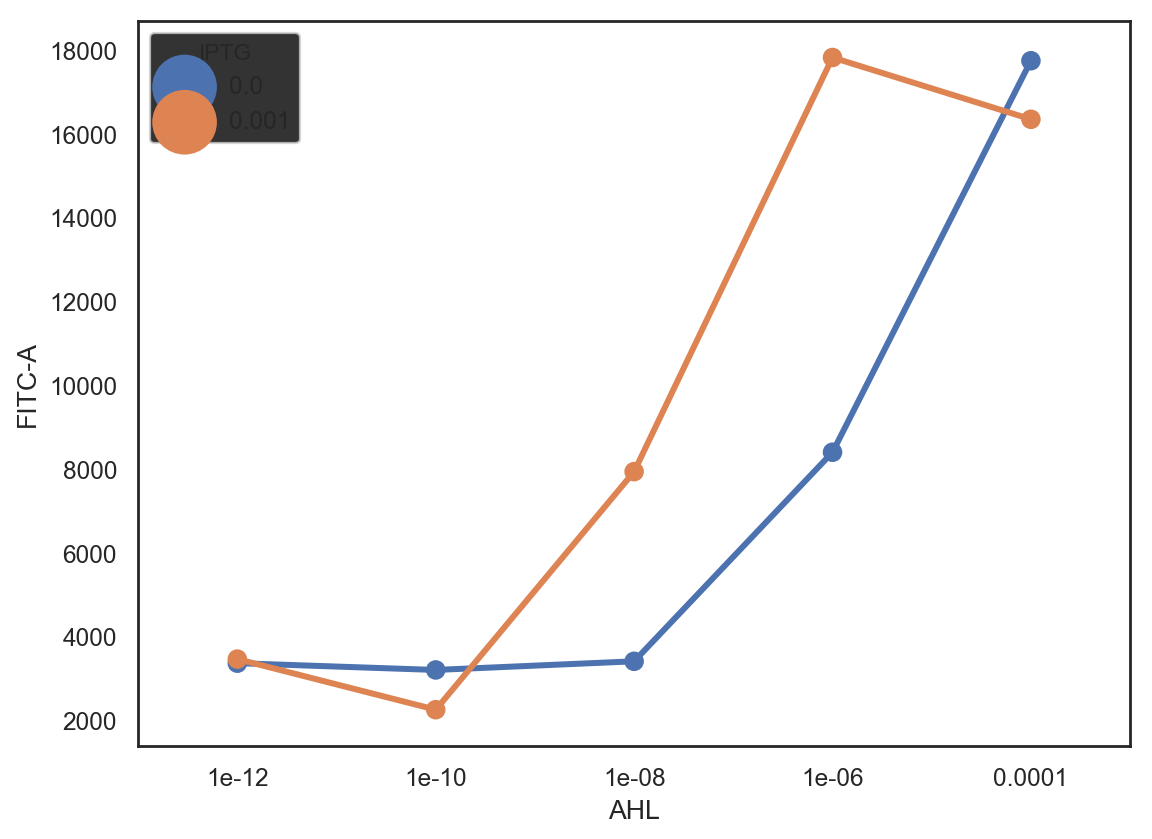

In [182]:
mfi = data.groupby(['AHL','IPTG'])['FITC-A'].median().reset_index()

f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=mfi)
f.savefig('Lux.png',dpi=600)

In [180]:
mfi

,AHL,IPTG,FITC-A
0,1.000000e-12,0.000,3347.930316
1,1.000000e-12,0.001,3444.050433
2,1.000000e-10,0.000,3185.060443
3,1.000000e-10,0.001,2236.320452
4,1.000000e-08,0.000,3391.540423
5,1.000000e-08,0.001,7918.080462
6,1.000000e-06,0.000,8380.880755
7,1.000000e-06,0.001,17801.530169
8,1.000000e-04,0.000,17724.991107
9,1.000000e-04,0.001,16328.580950


# Plot heatmaps showing absolute and relative induction

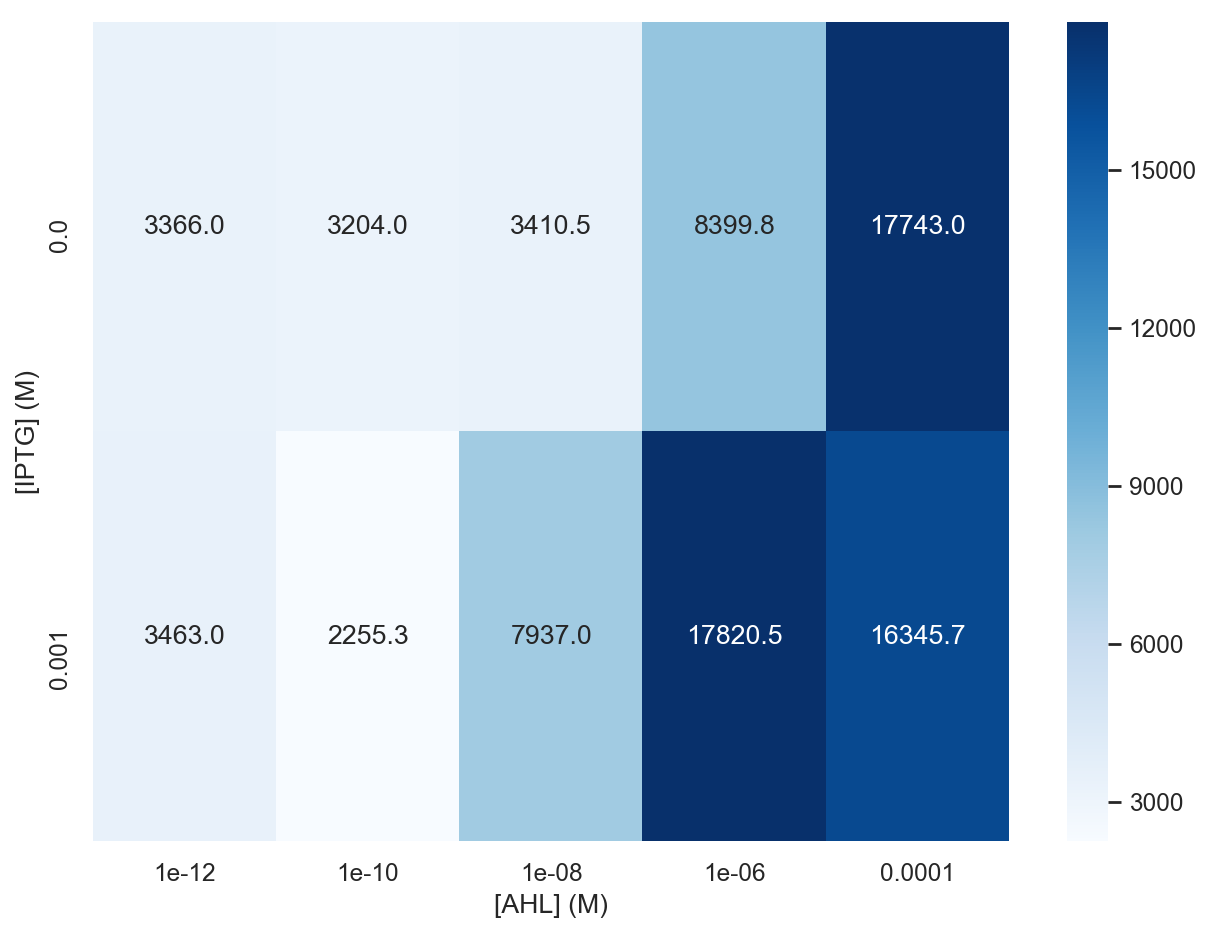

In [183]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)

#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mfi.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

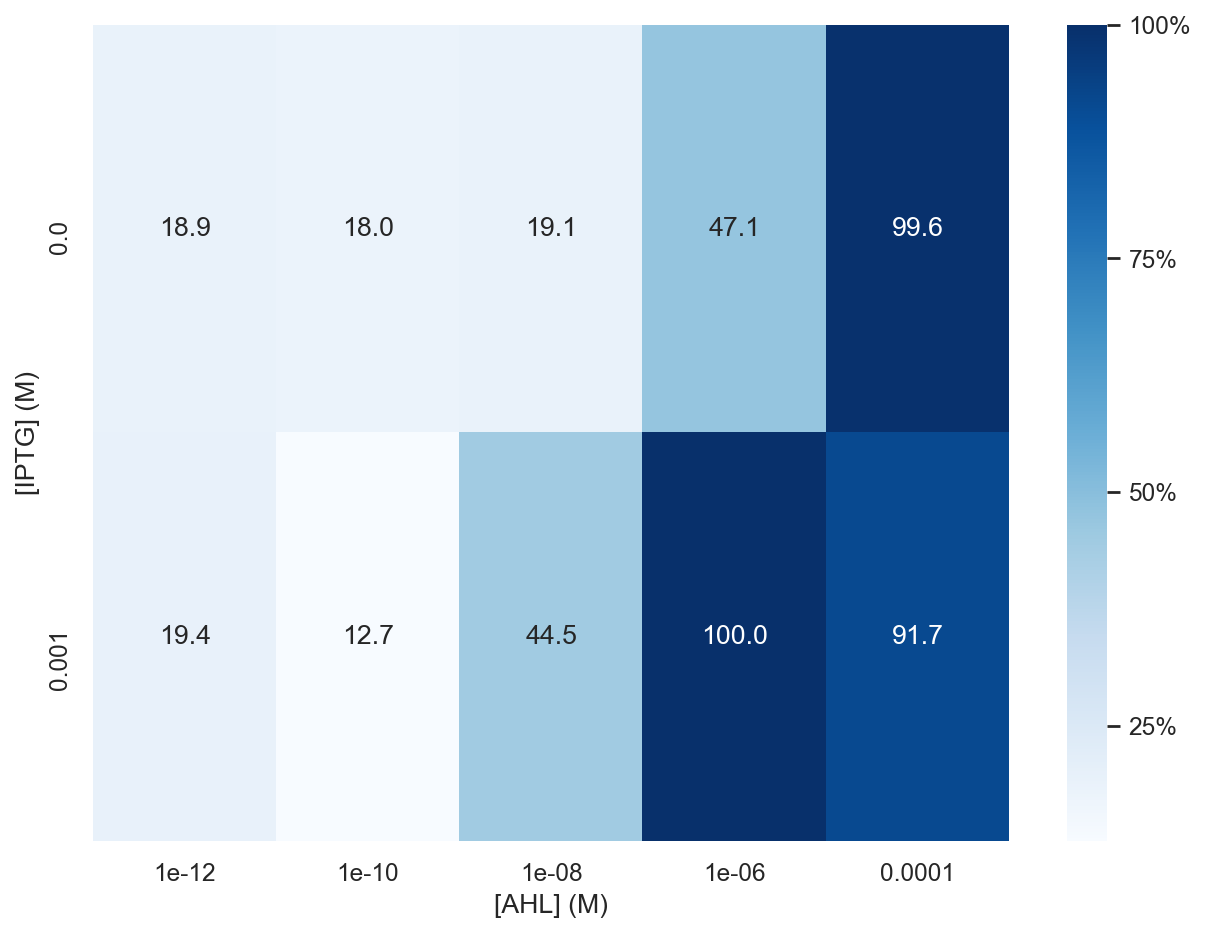

In [184]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
norm = mfi.copy()
norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

piv = norm.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [185]:

R =[]
for i in mfi.IPTG.unique():
    tmp = mfi[mfi.IPTG ==i]['FITC-A'].max()/mfi[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [186]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.000,5.537778
1,0.001,7.901736


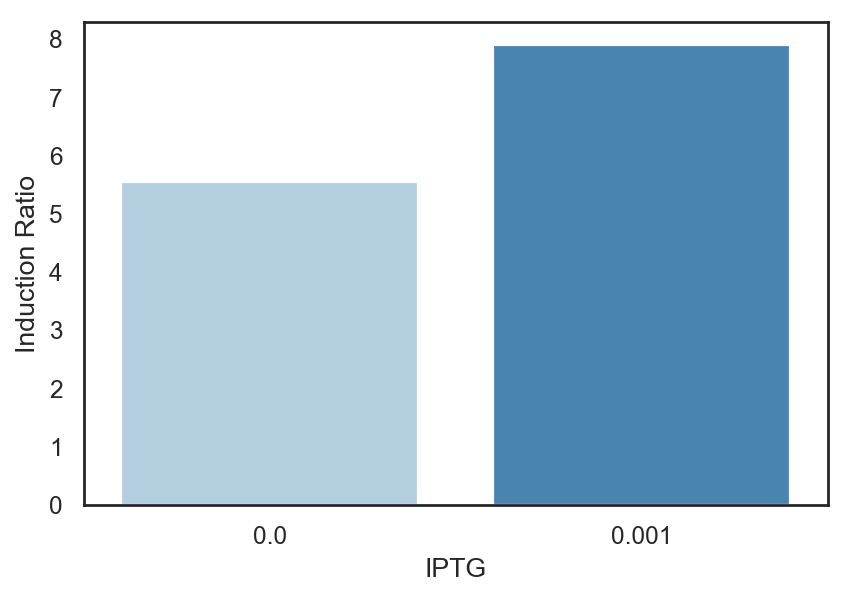

In [187]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [120]:


data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [121]:
data

,AHL,IPTG,FITC-A
0,1.000000e-14,0.000,87.410181
1,1.000000e-12,0.000,3408.650316
2,1.000000e-12,0.001,3526.703824
3,1.000000e-10,0.000,3237.155354
4,1.000000e-10,0.001,2333.458719
5,1.000000e-08,0.000,3444.413663
6,1.000000e-08,0.001,7966.254391
7,1.000000e-06,0.000,8352.352043
8,1.000000e-06,0.001,17842.530997
9,1.000000e-04,0.000,1316.996786


NameError: name 'axes' is not defined

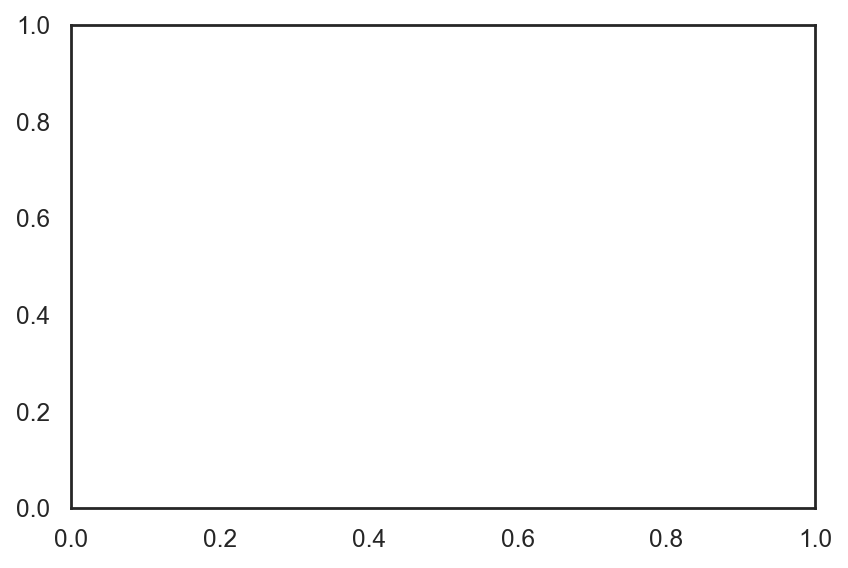

In [122]:
colors = ['#deebf7','#9ecae1','#3182bd']
fig, axes = plt.subplots(figsize=(6, 4))
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)
    print(a_,b_)
    y_fit = func(x, a_, b_)

    
    ax.plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i])
    ax.plot(np.log10(x), y_fit, '-',color = colors[i])
plt.show()

In [ ]:
tmp.AHL

In [ ]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [ ]:
print(a_, b_, c_, d_

75632